In [1]:
import itertools
from copy import deepcopy

import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt
import pandas as pd


from model import BaseModel
from true_causal_model import TrueCausalModel
from agents.causal_agents import HalfBlindAgent

%matplotlib inline
np.random.seed(0)

## Entrada: Orden parcial y aristas inválidas

In [2]:
DG = nx.DiGraph([("Reaccion", "Final"), ("Tratamiento", "Reaccion"), ("Tratamiento", "Final"), ("Enfermedad", "Final")])
causal_order = list(nx.topological_sort(DG))
invalid_edges = sorted([("Enfermedad", "Tratamiento")])
print(causal_order)

['Enfermedad', 'Tratamiento', 'Reaccion', 'Final']


## Genero creencias p<sub>ij</sub> iniciales

In [3]:
def is_a_valid_edge(x, y, causal_order, invalid_edges):
    if tuple(sorted((x, y))) in invalid_edges or causal_order.index(y) < causal_order.index(x):
        return False
    return True

In [4]:
def create_pij(variables, causal_order, invalid_edges):
    connection_tables = dict()
    for pair in itertools.combinations((variables), 2):
        proba = np.random.rand()
        if is_a_valid_edge(pair[0], pair[1], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[0], pair[1])] = proba
        elif is_a_valid_edge(pair[1], pair[0], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[1], pair[0])] = proba
    return connection_tables
def create_ebunch_from_beliefs(variables, connection_tables):
    ebunch = []
    for pair in connection_tables:
        r = np.random.rand()
        if r <= connection_tables[pair]:
            ebunch.append((pair.split('->')[0], pair.split('->')[1]))
    nodes = []
    for v in variables:
        flag = False
        for edge in ebunch:
            if v in edge:
                flag = True
                break
        if not flag:
            nodes.append(v)
    return ebunch, nodes


In [5]:
variables = sorted(["Tratamiento", "Reaccion", "Enfermedad", "Final"])
connection_tables = create_pij(variables, causal_order, invalid_edges)
for k in connection_tables:
    print(k, connection_tables[k])
ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)

print(ebunch)
print(nodes)

Enfermedad->Final 0.5488135039273248
Enfermedad->Reaccion 0.7151893663724195
Reaccion->Final 0.5448831829968969
Tratamiento->Final 0.4236547993389047
Tratamiento->Reaccion 0.6458941130666561
[('Enfermedad', 'Final'), ('Tratamiento', 'Final')]
['Reaccion']


## Genero grafo aleatorio e inicializo PGM

/home/ivan/Documentos/playing-against-nature/venv/lib/python3.7/site-packages/pgmpy/factors/discrete/CPD.py:504: UserWarning: Same ordering provided as current
  warn("Same ordering provided as current")


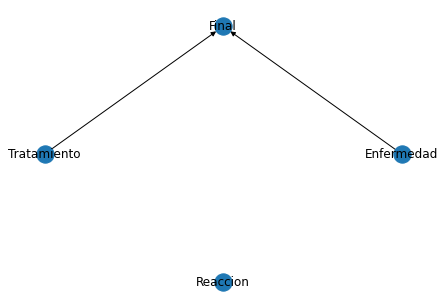

<Figure size 432x288 with 0 Axes>

In [6]:
complete_model = BaseModel('configs/model_parameters.json')
nature = TrueCausalModel(complete_model)
unknown_model = deepcopy(complete_model)
unknown_model.init_graph(ebunch, plot=False)
for node in nodes:
    unknown_model.digraph.add_node(node)
unknown_model.save_digraph_as_img("Nothing")
unknown_model.ebunch = ebunch
unknown_model.pgmodel = BayesianModel(ebunch)
unknown_model.pgmodel.add_nodes_from(nodes)

## Estructura real

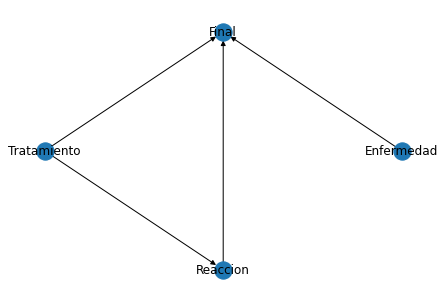

<Figure size 432x288 with 0 Axes>

In [7]:
complete_model.save_digraph_as_img("figures/gt_graph")

## Aprendizaje

In [23]:
agent = HalfBlindAgent(nature, unknown_model)
intervention_vars = agent.model.get_intervention_variables()
target_value = 1
target = {
    "variable": agent.model.get_target_variable(),
    "value" : target_value
}
rounds = 10

In [24]:
def update_connection_beliefs(variable, connection_tables, agent):
    for pair in connection_tables:
        var_one = pair.split("->")[0]
        var_two = pair.split("->")[1]
        nodes_to_remove = set(variables) - set(["Final", "Tratamiento", var_one, var_two])
        aux_model = deepcopy(agent.model)
        aux_model.pgmodel.remove_nodes_from(list(nodes_to_remove))
        aux_model.infer_system = VariableElimination(aux_model.pgmodel)
        p_sub = aux_model.get_joint_prob_observation(nature_response)
        connection_tables[pair] *= p_sub
    return connection_tables

### Entrenamiento

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 10.970275554648858
Enfermedad->Reaccion 5.952813012182298
Reaccion->Final 12.96564036674271
Tratamiento->Final 23.884110638700616
Tratamiento->Reaccion 12.96564036674271
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


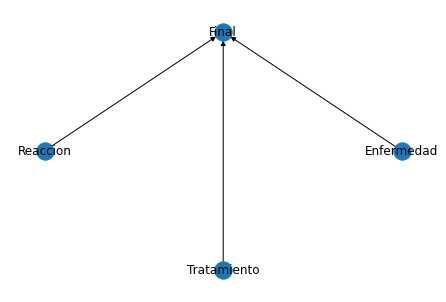

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.39510208787555323
Enfermedad->Reaccion 0.20993216817738872
Reaccion->Final 0.26001467505625175
Tratamiento->Final 1.0647167452236255
Tratamiento->Reaccion 0.26001467505625175
+---------------------------------+
Enfermedad = 1
Tratamiento = 1
Reaccion = 1
Final = 1


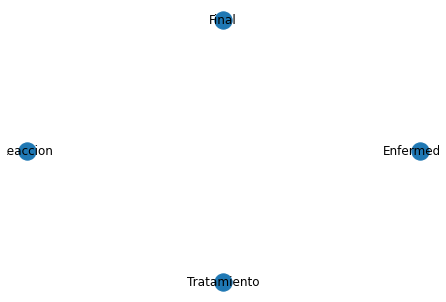

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0053486293960022194
Enfermedad->Reaccion 5.84262276612803e-05
Reaccion->Final 0.001509559709778123
Tratamiento->Final 0.29555731228246673
Tratamiento->Reaccion 0.001509559709778123
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1


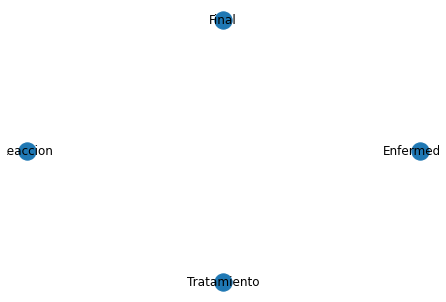

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.00018320733967098024
Enfermedad->Reaccion 4.294916168133446e-07
Reaccion->Final 1.2427790025668435e-05
Tratamiento->Final 0.011338062232948823
Tratamiento->Reaccion 1.2427790025668435e-05
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


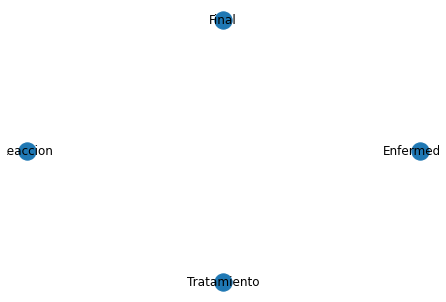

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.594580245289936e-06
Enfermedad->Reaccion 3.0915049249896258e-09
Reaccion->Final 6.121866693881753e-07
Tratamiento->Final 0.0010988484126968653
Tratamiento->Reaccion 6.121866693881753e-07
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


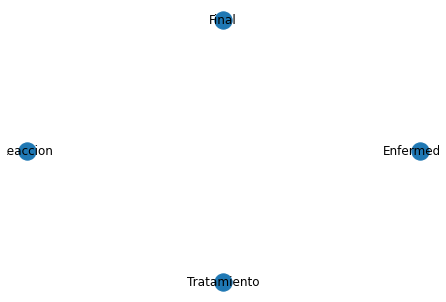

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+---------------------------------+
Enfermedad->Final 7.714025161058667e-07
Enfermedad->Reaccion 1.1628811239835023e-10
Reaccion->Final 2.4316868476198114e-08
Tratamiento->Final 0.00034499287682441214
Tratamiento->Reaccion 2.4316868476198114e-08
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1


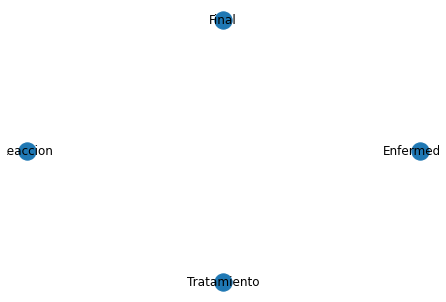

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.650075484800181e-07
Enfermedad->Reaccion 7.081568482789572e-16
Reaccion->Final 1.7870653866029337e-13
Tratamiento->Final 0.00019700152223025492
Tratamiento->Reaccion 1.7870653866029337e-13
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


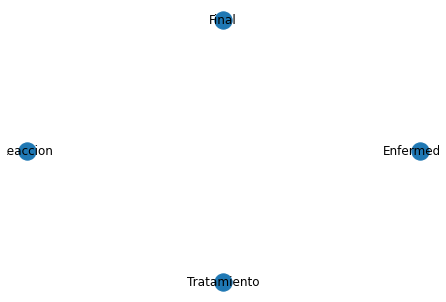

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.883367460295225e-07
Enfermedad->Reaccion 5.471686117655849e-16
Reaccion->Final 1.6943419705670803e-13
Tratamiento->Final 0.0001909574638247341
Tratamiento->Reaccion 1.6943419705670803e-13
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


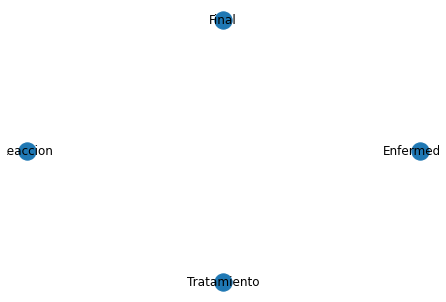

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 3.309906850680053e-08
Enfermedad->Reaccion 1.433170512314942e-18
Reaccion->Final 5.396320314026802e-16
Tratamiento->Final 2.6654612962442853e-05
Tratamiento->Reaccion 5.396320314026802e-16
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1


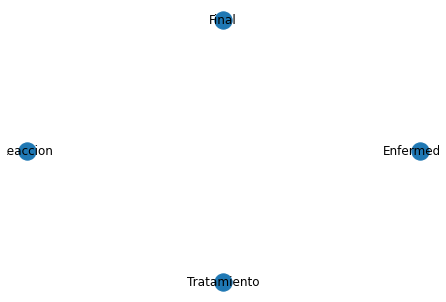

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.889905051744922e-09
Enfermedad->Reaccion 7.307093249945538e-20
Reaccion->Final 2.978494308168345e-17
Tratamiento->Final 2.5193728876069313e-06
Tratamiento->Reaccion 2.978494308168345e-17
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


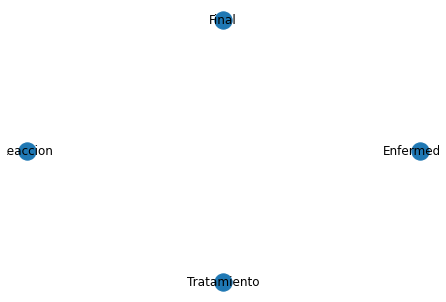

<Figure size 432x288 with 0 Axes>

In [25]:
for rnd in range(rounds):
    print("+---------------------------------+")
    for pair in connection_tables:
        print(pair, connection_tables[pair])
    print("+---------------------------------+")
    best_actions = agent.make_decision(target, intervention_vars)
    nature_response = agent.nature.action_simulator(intervention_vars, best_actions)
    agent.rewards_per_round.append(nature_response[target["variable"]])
    for var in nature_response:
        print("{} = {}".format(var, nature_response[var]))
    connection_tables = update_connection_beliefs(variables, connection_tables, agent)
    ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)
    unknown_model.init_graph(ebunch, plot=False)
    for node in nodes:
        unknown_model.digraph.add_node(node)
    unknown_model.save_digraph_as_img("Nothing")
    unknown_model.ebunch = ebunch
    unknown_model.pgmodel = BayesianModel(ebunch)
    unknown_model.pgmodel.add_nodes_from(nodes)
    agent = HalfBlindAgent(nature, unknown_model)